# Uploading files to collab

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsRegressor
from skopt.space import Integer, Real, Categorical
from sklearn.utils.class_weight import compute_sample_weight
import shap
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# ML

## 1. Preparation

### 1.1. Working with the table

In [2]:
db_2 = pd.read_excel('data_for_ML_unn.xlsx')
db_1 = db_2.drop(columns=['Sugar_encoded'])
db_1.insert(50, 'Sugar_encoded', db_2['Sugar_encoded'])
db_final = db_1.drop(columns=['Wine_strength'])
db_final.insert(0, 'Wine_strength', db_1['Wine_strength'])

In [3]:
colors = ['#a5678e','#e8b7d4', '#beb7d9', '#7eabd4', '#31539d']

In [4]:
db_final.describe()

,Wine_strength,1_vec_1,1_vec_2,1_vec_3,1_vec_4,1_vec_5,1_vec_6,1_vec_7,1_vec_8,1_vec_9,...,4_vec_8,4_vec_9,4_vec_10,%_4,Harvest_year,Color_Orange,Color_Pink,Color_Red,Color_White,Sugar_encoded
count,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,...,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.00000,14389.000000
mean,16.391203,0.060454,0.018292,0.079030,0.038532,0.019369,0.091676,0.173179,0.058107,-0.077239,...,0.005718,-0.003516,0.002559,0.002489,0.597499,0.003405,0.045521,0.551393,0.39968,1.167837
std,369.432331,0.253451,0.277256,0.367961,0.269708,0.334826,0.312388,0.321148,0.300864,0.304123,...,0.061957,0.049046,0.060644,0.020515,0.442962,0.058258,0.208451,0.497369,0.48985,0.700276
min,0.000000,-0.626064,-0.638262,-0.626405,-0.666614,-0.582963,-0.613744,-0.686419,-0.579507,-0.636982,...,-0.579029,-0.636982,-0.553962,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,12.500000,-0.093300,-0.179822,-0.322336,-0.146991,-0.297306,-0.223522,-0.115570,-0.241545,-0.339760,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,13.500000,0.096905,-0.037406,0.191290,-0.010493,0.071893,0.128300,0.310806,0.160546,-0.150012,...,0.000000,0.000000,0.000000,0.000000,0.887324,0.000000,0.000000,1.000000,0.00000,1.000000
75%,14.000000,0.257025,0.285380,0.427216,0.150550,0.328234,0.405705,0.433208,0.276289,0.099057,...,0.000000,0.000000,0.000000,0.000000,0.957746,0.000000,0.000000,1.000000,1.00000,1.000000
max,44328.000000,0.687540,0.629917,0.807477,0.717936,0.611457,0.630208,0.669380,0.683798,0.613503,...,0.502610,0.545916,0.516585,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,4.000000


### 1.2. Splitting data into test and train

In [5]:
def separation(x,y,n_splits,test_size):
    separation = []
    k_fold = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    for train_idx, test_idx in k_fold.split(x, y):
        separation.append((train_idx, test_idx))
    return separation

In [6]:
y = db_final.loc[:,'Sugar_encoded']
x = db_final.loc[:,'1_vec_1':]
cv = separation(x, y, 1, 0.2)
for train_idx, val_idx in cv:
    x_train, x_test = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

### 1.3. Functions for plotting and calculating metrics

In [7]:
def metrics(regr, x_train, y_train, y_test, y_pred, y1_pred):
    F1 = f1_score(y_test, y_pred, average='micro')
    F1_train = f1_score(y_train, y1_pred, average='micro')
    Accuracy = balanced_accuracy_score(y_test, y_pred)
    Accuracy_train = balanced_accuracy_score(y_train, y1_pred)

    print('f1_score:', F1)
    print('Accuracy:', Accuracy)
    print('f1_train:', F1_train)
    print('Accuracy_train:', Accuracy_train)
    return [F1_train, F1, Accuracy_train, Accuracy]

## 2. Random Forest Classification

In [33]:
class_RFC = RandomForestClassifier()

search_space = {"n_estimators": Integer(50,400),
    "criterion": Categorical(['entropy']),
    "min_samples_split": Real(0.01, 0.6),
    "min_samples_leaf": Real(0.01, 0.5),
    "max_depth": Integer(1, 12),
    "max_features": Integer(3, 24)}

df_error_train = pd.DataFrame()
x_model = x_train.copy().drop(['Sugar_encoded'],axis=1)

y_model = y_train.copy()
cv = separation(x_model, y_model, 5, 0.2)
count = 0

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
opt_RFC = BayesSearchCV(estimator = class_RFC, search_spaces=search_space, cv = separation(x_model, y_model, 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_RFC.fit(x_train01, y_model)

n_esti = opt_RFC.best_estimator_.n_estimators
criterion = opt_RFC.best_estimator_.criterion
min_leaf = opt_RFC.best_estimator_.min_samples_leaf
min_split = opt_RFC.best_estimator_.min_samples_split
depth = opt_RFC.best_estimator_.max_depth
max_feat = opt_RFC.best_estimator_.max_features

print('n_esti:', n_esti,'depth:', depth, 'criterion:', criterion, 'min_leaf:', min_leaf,'min_split:', min_split,'max_feat:', max_feat)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=0.27242035599996645, min_samples_split=0.22054344120494296, n_estimators=188; total time=   1.8s
[CV] END criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=0.27242035599996645, min_samples_split=0.22054344120494296, n_estimators=188; total time=   1.8s
[CV] END criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=0.27242035599996645, min_samples_split=0.22054344120494296, n_estimators=188; total time=   1.9s
[CV] END criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=0.27242035599996645, min_samples_split=0.22054344120494296, n_estimators=188; total time=   1.8s
[CV] END criterion=entropy, max_depth=10, max_features=4, min_samples_leaf=0.27242035599996645, min_samples_split=0.22054344120494296, n_estimators=188; total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=entropy, max_depth=3, max_features=10, min_samples_leaf=0.1215

In [34]:
count = 0

RFC_df = x_model[:]
RFC_df['Sugar'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    regr_RFC = RandomForestClassifier(n_estimators=n_esti, max_depth=depth, min_samples_leaf=min_leaf,
                                 min_samples_split=min_split, criterion=criterion, max_features=max_feat)
    regr_RFC.fit(x_train_mod, y_train_mod)
    y_pred = regr_RFC.predict(x_test_mod)
    y1_pred = regr_RFC.predict(x_train_mod)

    RFC_df['Sugar_train' + str(count)] = None
    RFC_df['Sugar_test' + str(count)] = None
    RFC_df['Sugar_train' + str(count)].iloc[train_idx] = y1_pred
    RFC_df['Sugar_test' + str(count)].iloc[val_idx] = y_pred
    df_error_train['Random Forest Classification' + str(count)] = metrics(regr_RFC, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.867564046895354
Accuracy: 0.3007919957280571
f1_train: 0.870655951346655
Accuracy_train: 0.2816755793226381



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8684324793747286
Accuracy: 0.24838460245419397
f1_train: 0.8618592528236316
Accuracy_train: 0.2589990852102105



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8610508033000435
Accuracy: 0.26035753244729404
f1_train: 0.8693527367506516
Accuracy_train: 0.28628314715381925



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.868866695614416
Accuracy: 0.2933190304125263
f1_train: 0.8730451781059948
Accuracy_train: 0.3017644284811797
f1_score: 0.864090316977855
Accuracy: 0.2459914182475158
f1_train: 0.8642484795829714
Accuracy_train: 0.2637137677088967



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4
0,0.870656,0.861859,0.869353,0.873045,0.864248
1,0.867564,0.868432,0.861051,0.868867,0.864090
2,0.281676,0.258999,0.286283,0.301764,0.263714
3,0.300792,0.248385,0.260358,0.293319,0.245991


## 3. Gradient Boosting Classification

In [35]:
class_GBC = GradientBoostingClassifier()

search_space = {"learning_rate": Real(0.05, 0.15),
    "n_estimators": Integer(50, 400),
    "max_depth": Integer(1, 6),
    "min_samples_leaf": Real(0.05, 0.5),
    "min_samples_split": Real(0.02, 0.6)}

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)

opt_GBC = BayesSearchCV(estimator = class_GBC, search_spaces=search_space, cv=separation(x_model, y_model,5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_GBC.fit(x_train01, y_model)

learning_rate = opt_GBC.best_estimator_.learning_rate
n_estimators = opt_GBC.best_estimator_.n_estimators
max_depth = opt_GBC.best_estimator_.max_depth
min_samples_leaf = opt_GBC.best_estimator_.min_samples_leaf
min_samples_split = opt_GBC.best_estimator_.min_samples_split

print('learning_rate:', learning_rate,'n_estimators:', n_estimators, 'max_depth:', max_depth, 'min_samples_leaf:', min_samples_leaf,'min_samples_split:', min_samples_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.13868501248366416, max_depth=6, min_samples_leaf=0.4469848564048299, min_samples_split=0.5722877797551468, n_estimators=166; total time=  22.2s
[CV] END learning_rate=0.13868501248366416, max_depth=6, min_samples_leaf=0.4469848564048299, min_samples_split=0.5722877797551468, n_estimators=166; total time=  22.2s
[CV] END learning_rate=0.13868501248366416, max_depth=6, min_samples_leaf=0.4469848564048299, min_samples_split=0.5722877797551468, n_estimators=166; total time=  22.4s
[CV] END learning_rate=0.13868501248366416, max_depth=6, min_samples_leaf=0.4469848564048299, min_samples_split=0.5722877797551468, n_estimators=166; total time=  22.5s
[CV] END learning_rate=0.13868501248366416, max_depth=6, min_samples_leaf=0.4469848564048299, min_samples_split=0.5722877797551468, n_estimators=166; total time=   9.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.148031794462

In [36]:
count = 0
GBC_df = x_model[:]
GBC_df['Sugar'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)

    class_GBC = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split)
    class_GBC.fit(x_train_mod, y_train_mod)
    y_pred = class_GBC.predict(x_test_mod)
    y1_pred = class_GBC.predict(x_train_mod)

    GBC_df['Sugar_train' + str(count)] = None
    GBC_df['Sugar_test' + str(count)] = None
    GBC_df['Sugar_train' + str(count)].iloc[train_idx] = y1_pred
    GBC_df['Sugar_test' + str(count)].iloc[val_idx] = y_pred

    df_error_train['Gradient Boosting Classification' + str(count)] = metrics(class_GBC, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.8792878853669127
Accuracy: 0.5242343317151501
f1_train: 0.9000868809730669
Accuracy_train: 0.5804978183142142



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.891445940078159
Accuracy: 0.5074582409939369
f1_train: 0.8980234578627281
Accuracy_train: 0.5662919665352422



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8849326964828484
Accuracy: 0.48144004358354336
f1_train: 0.8991094700260643
Accuracy_train: 0.5870289878873963



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.883195831524099
Accuracy: 0.4735703219117049
f1_train: 0.8981320590790617
Accuracy_train: 0.5638185367413351



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8936170212765957
Accuracy: 0.45990988521357423
f1_train: 0.8990008688097306
Accuracy_train: 0.5838417424605133


,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4,Gradient Boosting Classification0,Gradient Boosting Classification1,Gradient Boosting Classification2,Gradient Boosting Classification3,Gradient Boosting Classification4
0,0.870656,0.861859,0.869353,0.873045,0.864248,0.900087,0.898023,0.899109,0.898132,0.899001
1,0.867564,0.868432,0.861051,0.868867,0.864090,0.879288,0.891446,0.884933,0.883196,0.893617
2,0.281676,0.258999,0.286283,0.301764,0.263714,0.580498,0.566292,0.587029,0.563819,0.583842
3,0.300792,0.248385,0.260358,0.293319,0.245991,0.524234,0.507458,0.481440,0.473570,0.459910


## 4. Extreme Gradient Boosting (XGBoost)

In [10]:
class_XGB = XGBClassifier()

search_space = {"n_estimators": Integer(50, 350),
    "max_depth": Integer(2, 30),
    "subsample": Real(0.05, 1.0),
    "colsample_bytree": Real(0.05, 1.0)}

df_error_train = pd.DataFrame()
x_model = x_train.copy().drop(['Sugar_encoded'],axis=1)

y_model = y_train.copy()
cv = separation(x_model, y_model, 5, 0.2)
count = 0

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
opt_XGB = BayesSearchCV(estimator = class_XGB, search_spaces=search_space, cv = separation(x_model, y_model, 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_XGB.fit(x_train01, y_model)

n_estimators = opt_XGB.best_estimator_.n_estimators
max_depth = opt_XGB.best_estimator_.max_depth
subsample = opt_XGB.best_estimator_.subsample
colsample_bytree = opt_XGB.best_estimator_.colsample_bytree

print('n_estimators:', n_estimators,'max_depth:', max_depth, 'subsample:', subsample,'colsample_bytree:', colsample_bytree)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.9834625093268216, max_depth=24, n_estimators=117, subsample=0.8779613575719033; total time=  36.6s
[CV] END colsample_bytree=0.9834625093268216, max_depth=24, n_estimators=117, subsample=0.8779613575719033; total time=  37.4s
[CV] END colsample_bytree=0.9834625093268216, max_depth=24, n_estimators=117, subsample=0.8779613575719033; total time=  37.5s
[CV] END colsample_bytree=0.9834625093268216, max_depth=24, n_estimators=117, subsample=0.8779613575719033; total time=  38.1s
[CV] END colsample_bytree=0.9834625093268216, max_depth=24, n_estimators=117, subsample=0.8779613575719033; total time=  11.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.7067053137589105, max_depth=27, n_estimators=227, subsample=0.41281905113689105; total time=  30.7s
[CV] END colsample_bytree=0.7067053137589105, max_depth=27, n_estimators=227, subsample=0.41281905113689105; total time

In [11]:
count = 0
XGB_df = x_model[:]
XGB_df['Sugar'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)

    class_XGB = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, subsample = subsample, colsample_bytree = colsample_bytree)
    class_XGB.fit(x_train_mod, y_train_mod)
    y_pred = class_XGB.predict(x_test_mod)
    y1_pred = class_XGB.predict(x_train_mod)

    XGB_df['Sugar_train' + str(count)] = None
    XGB_df['Sugar_test' + str(count)] = None
    XGB_df['Sugar_train' + str(count)].iloc[train_idx] = y1_pred
    XGB_df['Sugar_test' + str(count)].iloc[val_idx] = y_pred

    df_error_train['XGBoosting Classification' + str(count)] = metrics(class_XGB, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.8810247503256622
Accuracy: 0.5650908053721353
f1_train: 0.9246307558644656
Accuracy_train: 0.6874410430908744



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8962223187147199
Accuracy: 0.5512649650008823
f1_train: 0.921698523023458
Accuracy_train: 0.6746041364284487



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8827616152844117
Accuracy: 0.4792182578311882
f1_train: 0.9228931364031278
Accuracy_train: 0.6891600798467912



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.8818931828050369
Accuracy: 0.519303688096049
f1_train: 0.9224587315377932
Accuracy_train: 0.6582929534690309
f1_score: 0.8931828050369084
Accuracy: 0.4703849172063381
f1_train: 0.9226759339704604
Accuracy_train: 0.6912936538134169



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,XGBoosting Classification0,XGBoosting Classification1,XGBoosting Classification2,XGBoosting Classification3,XGBoosting Classification4
0,0.924631,0.921699,0.922893,0.922459,0.922676
1,0.881025,0.896222,0.882762,0.881893,0.893183
2,0.687441,0.674604,0.689160,0.658293,0.691294
3,0.565091,0.551265,0.479218,0.519304,0.470385


## 5. General graphs

In [41]:
df_error_train.index = ['F1_train', 'F1_test', 'Accuracy_train', 'Accuracy_test']
df_error_train

,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4,Gradient Boosting Classification0,Gradient Boosting Classification1,Gradient Boosting Classification2,Gradient Boosting Classification3,Gradient Boosting Classification4,XGBoosting Classification0,XGBoosting Classification1,XGBoosting Classification2,XGBoosting Classification3,XGBoosting Classification4
F1_train,0.870656,0.861859,0.869353,0.873045,0.864248,0.900087,0.898023,0.899109,0.898132,0.899001,0.922242,0.920395,0.919852,0.920721,0.920938
F1_test,0.867564,0.868432,0.861051,0.868867,0.864090,0.879288,0.891446,0.884933,0.883196,0.893617,0.877551,0.893183,0.882327,0.884933,0.894920
Accuracy_train,0.281676,0.258999,0.286283,0.301764,0.263714,0.580498,0.566292,0.587029,0.563819,0.583842,0.675277,0.672958,0.672001,0.668206,0.693335
Accuracy_test,0.300792,0.248385,0.260358,0.293319,0.245991,0.524234,0.507458,0.481440,0.473570,0.459910,0.559295,0.541777,0.480313,0.539453,0.485350


In [42]:
df_error_train_1 = df_error_train.transpose()
f_get_name = lambda x: x[:-1]
df_error_train_1['Class'] = df_error_train_1.index
df_error_train_1['Class'] = df_error_train_1['Class'].apply(f_get_name)
df_error_train_1 = df_error_train_1.groupby('Class').agg(['mean', 'std'])
df_error_train_1.columns = ['_'.join(col).rstrip('_') for col in df_error_train_1.columns.values] 
df_error_train_1

,F1_train_mean,F1_train_std,F1_test_mean,F1_test_std,Accuracy_train_mean,Accuracy_train_std,Accuracy_test_mean,Accuracy_test_std
Class,,,,,,,,
Gradient Boosting Classification,0.898871,0.000839,0.886496,0.005927,0.576296,0.010554,0.489323,0.026092
Random Forest Classification,0.867832,0.004636,0.866001,0.003344,0.278487,0.017398,0.269769,0.025633
XGBoosting Classification,0.920830,0.000889,0.886583,0.007339,0.676355,0.009828,0.521238,0.035933


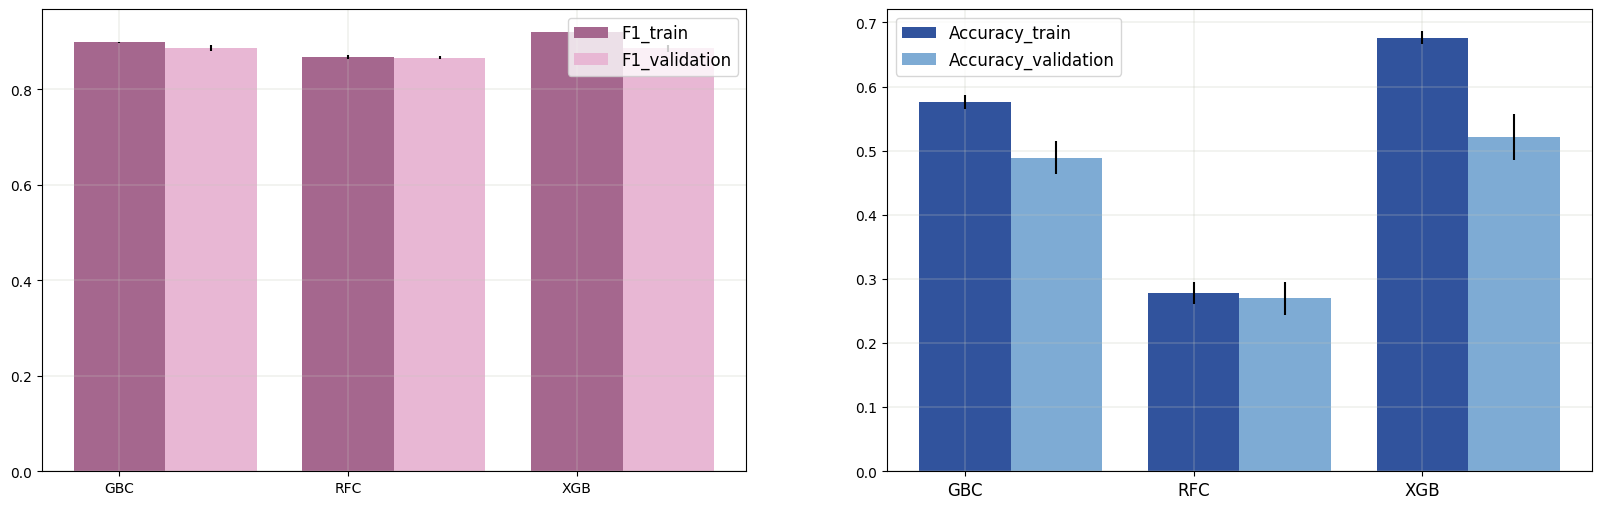

In [43]:
import matplotlib.patches as mpatches

barWidth = 0.4

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 =  np.arange(3)
br4 = [x + barWidth for x in br3]

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))

ax1.bar(br1, df_error_train_1['F1_train_mean'], color =colors[0], width = barWidth, label ='F1_train', yerr = df_error_train_1['F1_train_std'])
ax1.bar(br2, df_error_train_1['F1_test_mean'], color =colors[1], width = barWidth, label ='F1_validation', yerr = df_error_train_1['F1_test_std'])

ax2.bar(br3, df_error_train_1['Accuracy_train_mean'], color =colors[4], width = barWidth, label ='Accuracy_train', yerr = df_error_train_1['Accuracy_train_std'])
ax2.bar(br4, df_error_train_1['Accuracy_test_mean'], color =colors[3], width = barWidth, label ='Accuracy_validation', yerr = df_error_train_1['Accuracy_test_std'])

plt.xticks(br1, ['GBC','RFC','XGB'], fontsize = 12)

ax1.grid(color='#C3C6BA', linewidth=0.3)
ax2.grid(color='#C3C6BA', linewidth=0.3)


ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)


In [12]:
import joblib
joblib.dump(class_XGB, 'sugar.pkl')

['sugar.pkl']